# GPX File Analysis

In this notebook, we'll analyze the GPX file from a cycling activity. GPX (GPS Exchange Format) files contain location data including latitude, longitude, elevation, and timestamps from activities like cycling, running, or hiking.


## Import Required Libraries

First, let's import the necessary libraries for data processing and visualization.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from datetime import datetime
import folium
import math
from IPython.display import display

# Set plot styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load and Parse the GPX File

Now let's load the GPX file and extract the track points data.


In [2]:
# File path to the GPX file
gpx_file_path = r"..\..\Morning_Ride.gpx"

# Import gpxpy to handle GPX files
import gpxpy
import gpxpy.gpx

# Read the GPX file
with open(gpx_file_path, "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# Get basic information
print(f"File contains {len(gpx.tracks)} track(s)")
track = gpx.tracks[0]
print(f"Track name: {track.name}")
print(f"Track type: {track.type}")
print(f"Number of track segments: {len(track.segments)}")
segment = track.segments[0]
print(f"Number of track points: {len(segment.points)}")

# Start time from metadata
start_time = gpx.time
print(f"Activity start time: {start_time}")

File contains 1 track(s)
Track name: Morning Ride
Track type: cycling
Number of track segments: 1
Number of track points: 7918
Activity start time: 2024-12-01 18:01:54+00:00


## Convert GPX Data to DataFrame

Let's convert the track points to a pandas DataFrame for easier analysis.


In [3]:
# Extract data from track points
data = []
segment = gpx.tracks[0].segments[0]

for point in segment.points:
    data_point = {
        "latitude": point.latitude,
        "longitude": point.longitude,
        "elevation": point.elevation,
        "time": point.time,
    }
    data.append(data_point)

# Create DataFrame
df = pd.DataFrame(data)

# Display first few rows
print(f"DataFrame shape: {df.shape}")
df.head()

DataFrame shape: (7918, 4)


,latitude,longitude,elevation,time
0,47.579221,-122.000199,128.3,2024-12-01 18:05:07+00:00
1,47.579163,-122.000361,128.4,2024-12-01 18:05:08+00:00
2,47.579192,-122.000404,128.5,2024-12-01 18:05:09+00:00
3,47.579220,-122.000462,128.5,2024-12-01 18:05:10+00:00
4,47.579246,-122.000518,128.5,2024-12-01 18:05:11+00:00


## Calculate Time Differences, Distances, and Speeds

Now we can calculate the time between points, distances between consecutive points, and instantaneous speeds.


In [4]:
# Function to calculate the distance between two points using the Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r * 1000  # Return in meters


# Calculate time differences in seconds
df["prev_time"] = df["time"].shift(1)
df["time_diff"] = (df["time"] - df["prev_time"]).dt.total_seconds()

# Calculate distance between consecutive points
df["prev_lat"] = df["latitude"].shift(1)
df["prev_lon"] = df["longitude"].shift(1)
df["distance"] = df.apply(
    lambda row: haversine_distance(
        row["prev_lat"], row["prev_lon"], row["latitude"], row["longitude"]
    )
    if not pd.isna(row["prev_lat"])
    else 0,
    axis=1,
)

# Calculate cumulative distance
df["cumulative_distance"] = df["distance"].cumsum()

# Calculate speed in km/h
df["speed_mps"] = df["distance"] / df["time_diff"]  # meters per second
df["speed_kmh"] = df["speed_mps"] * 3.6  # convert to km/h

# Replace infinity values (from division by zero) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the first few rows with new calculations
print(f"Total distance: {df['cumulative_distance'].iloc[-1] / 1000:.2f} km")
print(
    f"Total time: {(df['time'].iloc[-1] - df['time'].iloc[0]).total_seconds() / 60:.2f} minutes"
)
print(f"Average speed: {df['speed_kmh'].mean():.2f} km/h")

df[
    ["latitude", "longitude", "time", "distance", "cumulative_distance", "speed_kmh"]
].head()

Total distance: 39.81 km
Total time: 143.95 minutes
Average speed: 17.42 km/h


,latitude,longitude,time,distance,cumulative_distance,speed_kmh
0,47.579221,-122.000199,2024-12-01 18:05:07+00:00,0.000000,0.000000,NaN
1,47.579163,-122.000361,2024-12-01 18:05:08+00:00,13.756844,13.756844,49.524640
2,47.579192,-122.000404,2024-12-01 18:05:09+00:00,4.560862,18.317707,16.419104
3,47.579220,-122.000462,2024-12-01 18:05:10+00:00,5.349819,23.667525,19.259348
4,47.579246,-122.000518,2024-12-01 18:05:11+00:00,5.099254,28.766780,18.357316


## Elevation Analysis

Let's analyze the elevation changes throughout the ride.


Total elevation gain: 386.6 meters
Total elevation loss: 378.0 meters


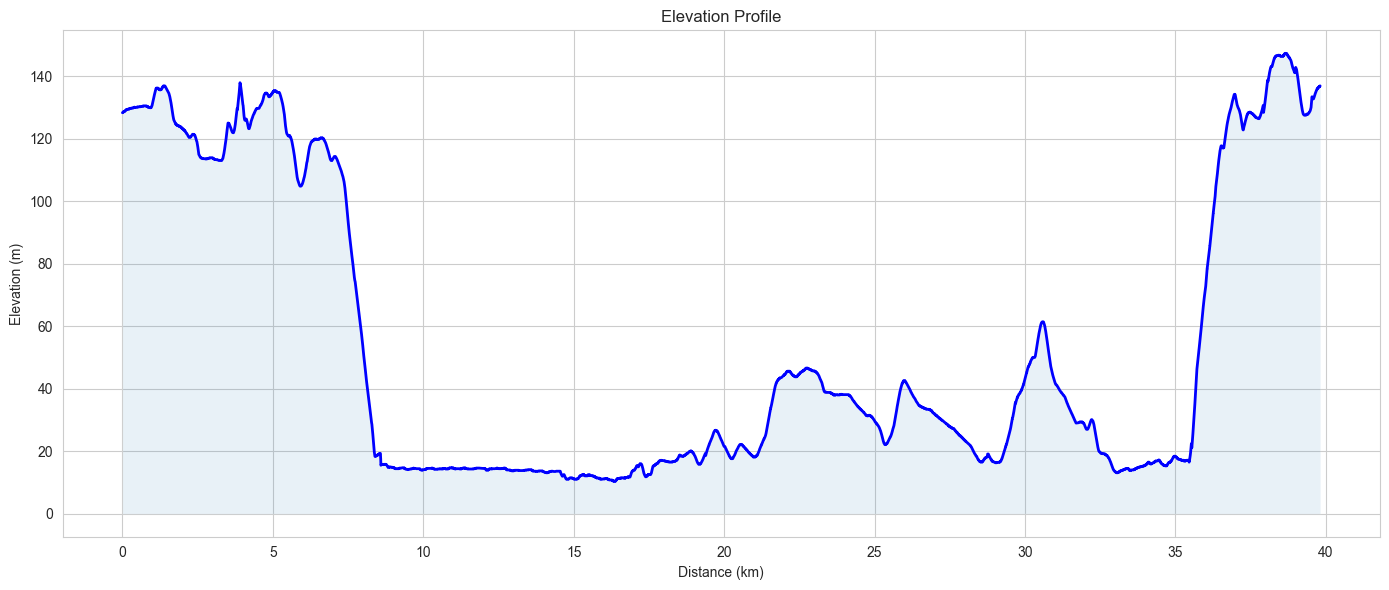

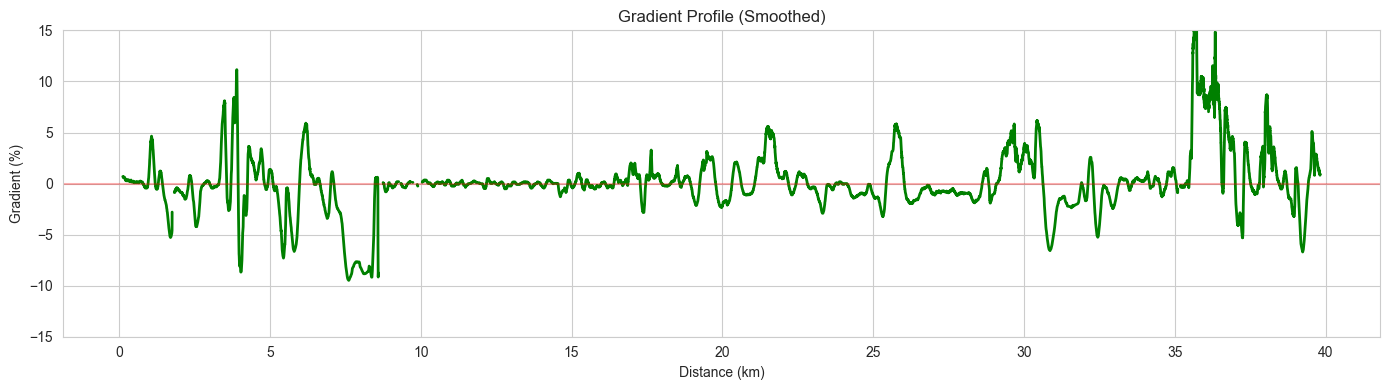

In [5]:
# Calculate elevation differences
df["prev_elevation"] = df["elevation"].shift(1)
df["elevation_diff"] = df["elevation"] - df["prev_elevation"]

# Calculate total elevation gain and loss
elevation_gain = df.loc[df["elevation_diff"] > 0, "elevation_diff"].sum()
elevation_loss = abs(df.loc[df["elevation_diff"] < 0, "elevation_diff"].sum())

print(f"Total elevation gain: {elevation_gain:.1f} meters")
print(f"Total elevation loss: {elevation_loss:.1f} meters")

# Plot elevation profile
plt.figure(figsize=(14, 6))
plt.plot(df["cumulative_distance"] / 1000, df["elevation"], "b-", linewidth=2)
plt.fill_between(df["cumulative_distance"] / 1000, df["elevation"], alpha=0.1)
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Elevation Profile")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot gradient
df["gradient"] = df["elevation_diff"] / df["distance"] * 100  # in percentage
df["gradient"] = df["gradient"].replace([np.inf, -np.inf], np.nan)
df["gradient_smooth"] = df["gradient"].rolling(window=20).mean()  # smoothed gradient

plt.figure(figsize=(14, 4))
plt.plot(df["cumulative_distance"] / 1000, df["gradient_smooth"], "g-", linewidth=2)
plt.axhline(y=0, color="r", linestyle="-", alpha=0.3)
plt.xlabel("Distance (km)")
plt.ylabel("Gradient (%)")
plt.title("Gradient Profile (Smoothed)")
plt.grid(True)
plt.ylim(-15, 15)  # Adjust based on your data
plt.tight_layout()
plt.show()

## Route Visualization

Let's visualize the cycling route on an interactive map.


In [ ]:
# Create a map centered at the mean location of the ride
mean_lat = df["latitude"].mean()
mean_lon = df["longitude"].mean()
ride_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)


# Create color-coded route based on speed
def get_color(speed):
    """Return a color based on speed"""
    if pd.isna(speed):
        return "#3186cc"  # default blue
    elif speed < 10:
        return "#1a9850"  # slow - green
    elif speed < 20:
        return "#fee08b"  # medium - yellow
    elif speed < 30:
        return "#fc8d59"  # fast - orange
    else:
        return "#d73027"  # very fast - red


# Add a thinned-out version of the route to improve performance
# Sample every Nth point
sampling_rate = max(1, len(df) // 500)  # Sample to get around 500 points
sampled_df = df.iloc[::sampling_rate].copy()

# Plot the route with color based on speed
for i in range(len(sampled_df) - 1):
    start_point = [sampled_df.iloc[i]["latitude"], sampled_df.iloc[i]["longitude"]]
    end_point = [
        sampled_df.iloc[i + 1]["latitude"],
        sampled_df.iloc[i + 1]["longitude"],
    ]

    speed = sampled_df.iloc[i]["speed_kmh"]
    color = get_color(speed)

    folium.PolyLine(
        [start_point, end_point], color=color, weight=4, opacity=0.8
    ).add_to(ride_map)

# Add markers for start and end points
folium.Marker(
    location=[df.iloc[0]["latitude"], df.iloc[0]["longitude"]],
    popup="Start",
    icon=folium.Icon(color="green", icon="play", prefix="fa"),
).add_to(ride_map)

folium.Marker(
    location=[df.iloc[-1]["latitude"], df.iloc[-1]["longitude"]],
    popup="End",
    icon=folium.Icon(color="red", icon="stop", prefix="fa"),
).add_to(ride_map)

# Display the map
display(ride_map)

# Also save the map to an HTML file for easy viewing outside the notebook
map_file = "ride_map.html"
ride_map.save(map_file)
print(f"Map saved to {map_file}")

In [ ]:
# Ride Statistics Analysis

# Create a summary of key ride metrics
print("\n==== Ride Summary ====")
total_distance = df["cumulative_distance"].iloc[-1] / 1000  # km
total_time_seconds = (df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds()
total_time_minutes = total_time_seconds / 60
total_time_hours = total_time_minutes / 60
avg_speed = total_distance / total_time_hours  # km/h

# Time moving (excluding stops)
moving_time_seconds = df[df["speed_kmh"] > 1]["time_diff"].sum()
moving_time_minutes = moving_time_seconds / 60
moving_time_hours = moving_time_minutes / 60
avg_moving_speed = total_distance / moving_time_hours  # km/h

# Maximum values
max_speed = df["speed_kmh"].max()
max_elevation = df["elevation"].max()
min_elevation = df["elevation"].min()
elevation_range = max_elevation - min_elevation

# Print statistics
print(f"Date: {df['time'].iloc[0].strftime('%Y-%m-%d')}")
print(f"Total Distance: {total_distance:.2f} km")
print(
    f"Total Time: {int(total_time_hours)}h {int(total_time_minutes % 60)}m {int(total_time_seconds % 60)}s"
)
print(
    f"Moving Time: {int(moving_time_hours)}h {int(moving_time_minutes % 60)}m {int(moving_time_seconds % 60)}s"
)
print(f"Average Speed: {avg_speed:.2f} km/h")
print(f"Average Moving Speed: {avg_moving_speed:.2f} km/h")
print(f"Maximum Speed: {max_speed:.2f} km/h")
print(f"Elevation Gain: {elevation_gain:.1f} m")
print(f"Elevation Loss: {elevation_loss:.1f} m")
print(f"Maximum Elevation: {max_elevation:.1f} m")
print(f"Minimum Elevation: {min_elevation:.1f} m")
print(f"Elevation Range: {elevation_range:.1f} m")

# Create a speed distribution histogram
plt.figure(figsize=(10, 6))
sns.histplot(df["speed_kmh"].dropna(), bins=30, kde=True)
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.title("Speed Distribution")
plt.axvline(
    x=avg_moving_speed,
    color="r",
    linestyle="--",
    label=f"Avg Moving Speed: {avg_moving_speed:.2f} km/h",
)
plt.legend()
plt.grid(True)
plt.show()

# Create a pace chart (time spent at different speed ranges)
speed_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 100]
speed_labels = [
    "0-5",
    "5-10",
    "10-15",
    "15-20",
    "20-25",
    "25-30",
    "30-35",
    "35-40",
    "40+",
]

df["speed_category"] = pd.cut(
    df["speed_kmh"], bins=speed_bins, labels=speed_labels, right=False
)
time_in_zones = df.groupby("speed_category")["time_diff"].sum() / 60  # minutes

plt.figure(figsize=(12, 6))
time_in_zones.plot(kind="bar", color="skyblue")
plt.xlabel("Speed Range (km/h)")
plt.ylabel("Time (minutes)")
plt.title("Time Spent in Different Speed Zones")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

In [ ]:
# Heart Rate Analysis

# Re-parse the GPX file to extract heart rate data
import gpxpy
import gpxpy.gpx
import numpy as np


# Function to extract heart rate from a track point
def extract_heart_rate(point):
    """Extract heart rate from GPX track point extensions if available"""
    if hasattr(point, "extensions") and point.extensions:
        for extension in point.extensions:
            # Look for heart rate in TrackPointExtension
            hr_elements = extension.findall(
                ".//{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr"
            )
            if hr_elements and len(hr_elements) > 0:
                try:
                    return int(hr_elements[0].text)
                except (ValueError, TypeError):
                    pass
    return None


# Load GPX file
with open(gpx_file_path, "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# Extract heart rate data
hr_data = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            hr = extract_heart_rate(point)
            if hr is not None:
                hr_data.append(
                    {
                        "time": point.time,
                        "heart_rate": hr,
                        "latitude": point.latitude,
                        "longitude": point.longitude,
                        "elevation": point.elevation,
                    }
                )

# Create DataFrame for heart rate data
if hr_data:
    hr_df = pd.DataFrame(hr_data)

    # Merge with the distance data from the main DataFrame
    # First create a temporary DataFrame with just the time and cumulative distance
    distance_df = df[["time", "cumulative_distance", "speed_kmh"]].copy()

    # Merge the heart rate data with the distance data
    hr_df = pd.merge_asof(
        hr_df.sort_values("time"),
        distance_df.sort_values("time"),
        on="time",
        direction="nearest",
    )

    print(f"Heart rate data available: {len(hr_df)} points")
    print(f"Average heart rate: {hr_df['heart_rate'].mean():.1f} bpm")
    print(f"Maximum heart rate: {hr_df['heart_rate'].max()} bpm")

    # Plot heart rate over time
    plt.figure(figsize=(14, 6))
    plt.plot(
        hr_df["cumulative_distance"] / 1000, hr_df["heart_rate"], "r-", linewidth=2
    )
    plt.xlabel("Distance (km)")
    plt.ylabel("Heart Rate (bpm)")
    plt.title("Heart Rate Throughout the Ride")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot heart rate vs. speed
    plt.figure(figsize=(10, 6))
    plt.scatter(hr_df["speed_kmh"], hr_df["heart_rate"], alpha=0.5)
    plt.xlabel("Speed (km/h)")
    plt.ylabel("Heart Rate (bpm)")
    plt.title("Heart Rate vs. Speed")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Define heart rate zones (example zones, adjust as needed)
    zones = [
        (0, 110, "Zone 1 - Recovery"),
        (110, 130, "Zone 2 - Endurance"),
        (130, 150, "Zone 3 - Tempo"),
        (150, 170, "Zone 4 - Threshold"),
        (170, 250, "Zone 5 - Maximum"),
    ]

    # Calculate time in each zone
    zone_times = []
    for i, (lower, upper, name) in enumerate(zones):
        if i == 0:
            mask = hr_df["heart_rate"] < upper
        elif i == len(zones) - 1:
            mask = hr_df["heart_rate"] >= lower
        else:
            mask = (hr_df["heart_rate"] >= lower) & (hr_df["heart_rate"] < upper)

        time_in_zone = hr_df.loc[mask, "time"].count()  # count points in this zone
        if time_in_zone > 0:
            # Assuming points are roughly equally spaced in time
            total_time_minutes = (
                hr_df["time"].max() - hr_df["time"].min()
            ).total_seconds() / 60
            percentage = (time_in_zone / len(hr_df)) * 100
            minutes = (percentage / 100) * total_time_minutes
            zone_times.append((name, percentage, minutes))

    # Plot time in heart rate zones
    if zone_times:
        zones, percentages, minutes = zip(*zone_times)

        plt.figure(figsize=(12, 6))
        plt.bar(zones, minutes, color="coral")
        plt.xlabel("Heart Rate Zone")
        plt.ylabel("Time (minutes)")
        plt.title("Time Spent in Each Heart Rate Zone")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        # Pie chart of time in zones
        plt.figure(figsize=(10, 10))
        plt.pie(
            percentages,
            labels=zones,
            autopct="%1.1f%%",
            startangle=90,
            colors=["green", "blue", "yellow", "orange", "red"],
        )
        plt.axis("equal")
        plt.title("Percentage of Time in Each Heart Rate Zone")
        plt.tight_layout()
        plt.show()

else:
    print("No heart rate data found in the GPX file.")

In [ ]:
# Ride Segment Analysis

# Function to identify ride segments based on elevation changes
def identify_segments(
    df,
    min_climb_length=0.3,
    min_climb_gradient=3,
    min_descent_length=0.3,
    min_descent_gradient=-3,
):
    """
    Identify segments (climbs, descents, flats) in the ride based on elevation profile

    Parameters:
    df - DataFrame with ride data
    min_climb_length - Minimum length (km) for a climb segment
    min_climb_gradient - Minimum average gradient (%) for a climb segment
    min_descent_length - Minimum length (km) for a descent segment
    min_descent_gradient - Maximum average gradient (%) for a descent segment

    Returns:
    List of segment dictionaries
    """
    segments = []
    current_segment = None
    segment_type = None

    for i in range(1, len(df)):
        # Current point data
        current_dist = df.iloc[i]["cumulative_distance"] / 1000  # km
        prev_dist = df.iloc[i - 1]["cumulative_distance"] / 1000  # km
        current_ele = df.iloc[i]["elevation"]
        prev_ele = df.iloc[i - 1]["elevation"]

        if i == 1:  # Start first segment
            current_segment = {
                "start_idx": 0,
                "start_dist": 0,
                "start_ele": df.iloc[0]["elevation"],
                "points": [0, i],
            }

            # Determine initial segment type
            if df.iloc[i - 1 : i + 10]["gradient_smooth"].mean() > min_climb_gradient:
                segment_type = "climb"
            elif (
                df.iloc[i - 1 : i + 10]["gradient_smooth"].mean() < min_descent_gradient
            ):
                segment_type = "descent"
            else:
                segment_type = "flat"

            current_segment["type"] = segment_type
            continue

        # Check if we need to end current segment and start a new one
        current_gradient = (
            df.iloc[i - 5 : i + 5]["gradient_smooth"].mean()
            if i > 5 and i < len(df) - 5
            else df.iloc[i]["gradient_smooth"]
        )

        # Transition logic
        new_segment_type = None

        if segment_type == "climb":
            if current_gradient < min_climb_gradient / 2:  # End of climb
                if current_gradient < min_descent_gradient:
                    new_segment_type = "descent"
                else:
                    new_segment_type = "flat"
        elif segment_type == "descent":
            if current_gradient > min_descent_gradient / 2:  # End of descent
                if current_gradient > min_climb_gradient:
                    new_segment_type = "climb"
                else:
                    new_segment_type = "flat"
        else:  # flat
            if current_gradient > min_climb_gradient:
                new_segment_type = "climb"
            elif current_gradient < min_descent_gradient:
                new_segment_type = "descent"

        # Update current segment points
        current_segment["points"].append(i)

        # If segment type changed, finish current segment and start a new one
        if new_segment_type is not None and new_segment_type != segment_type:
            # Finish current segment
            end_idx = i
            current_segment["end_idx"] = end_idx
            current_segment["end_dist"] = current_dist
            current_segment["end_ele"] = current_ele
            current_segment["length"] = current_dist - current_segment["start_dist"]
            current_segment["elevation_change"] = (
                current_ele - current_segment["start_ele"]
            )

            if current_segment["length"] > 0:
                current_segment["avg_gradient"] = current_segment[
                    "elevation_change"
                ] / (current_segment["length"] * 10)  # % gradient
            else:
                current_segment["avg_gradient"] = 0

            # Only keep segments that meet minimum requirements
            if (
                (
                    segment_type == "climb"
                    and current_segment["length"] >= min_climb_length
                    and current_segment["avg_gradient"] >= min_climb_gradient
                )
                or (
                    segment_type == "descent"
                    and current_segment["length"] >= min_descent_length
                    and current_segment["avg_gradient"] <= min_descent_gradient
                )
                or (
                    segment_type == "flat"
                    and current_segment["length"]
                    >= max(min_climb_length, min_descent_length)
                )
            ):
                # Calculate segment stats
                segment_df = df.iloc[
                    current_segment["start_idx"] : current_segment["end_idx"] + 1
                ]
                current_segment["avg_speed"] = segment_df["speed_kmh"].mean()
                current_segment["max_speed"] = segment_df["speed_kmh"].max()

                # If heart rate data available
                if "heart_rate" in df.columns:
                    current_segment["avg_hr"] = segment_df["heart_rate"].mean()
                    current_segment["max_hr"] = segment_df["heart_rate"].max()

                segments.append(current_segment)

            # Start new segment
            segment_type = new_segment_type
            current_segment = {
                "type": segment_type,
                "start_idx": end_idx,
                "start_dist": current_dist,
                "start_ele": current_ele,
                "points": [i],
            }

    # Add the final segment if it exists
    if current_segment:
        end_idx = len(df) - 1
        current_segment["end_idx"] = end_idx
        current_segment["end_dist"] = df.iloc[end_idx]["cumulative_distance"] / 1000
        current_segment["end_ele"] = df.iloc[end_idx]["elevation"]
        current_segment["length"] = (
            current_segment["end_dist"] - current_segment["start_dist"]
        )
        current_segment["elevation_change"] = (
            current_segment["end_ele"] - current_segment["start_ele"]
        )

        if current_segment["length"] > 0:
            current_segment["avg_gradient"] = current_segment["elevation_change"] / (
                current_segment["length"] * 10
            )
        else:
            current_segment["avg_gradient"] = 0

        # Calculate segment stats
        segment_df = df.iloc[
            current_segment["start_idx"] : current_segment["end_idx"] + 1
        ]
        current_segment["avg_speed"] = segment_df["speed_kmh"].mean()
        current_segment["max_speed"] = segment_df["speed_kmh"].max()

        # If heart rate data available
        if "heart_rate" in df.columns:
            current_segment["avg_hr"] = segment_df["heart_rate"].mean()
            current_segment["max_hr"] = segment_df["heart_rate"].max()

        segments.append(current_segment)

    return segments


# Identify segments in the ride
segments = identify_segments(df)

# Display segment information
print(f"Found {len(segments)} notable segments in the ride")
print("\nSegment Analysis:")
print("-" * 80)
print(
    f"{'Type':<10} {'Start':<8} {'End':<8} {'Length':<8} {'Elev Δ':<8} {'Gradient':<8} {'Avg Speed':<10} {'Max Speed':<10}"
)
print("-" * 80)

for i, segment in enumerate(segments):
    segment_type = segment["type"]
    start = f"{segment['start_dist']:.1f}km"
    end = f"{segment['end_dist']:.1f}km"
    length = f"{segment['length']:.1f}km"
    elev = f"{segment['elevation_change']:.0f}m"
    gradient = f"{segment['avg_gradient']:.1f}%"
    avg_speed = f"{segment['avg_speed']:.1f}km/h"
    max_speed = f"{segment['max_speed']:.1f}km/h"

    print(
        f"{segment_type:<10} {start:<8} {end:<8} {length:<8} {elev:<8} {gradient:<8} {avg_speed:<10} {max_speed:<10}"
    )

# Visualize segments on elevation profile
plt.figure(figsize=(14, 8))

# Plot the full elevation profile
plt.plot(
    df["cumulative_distance"] / 1000, df["elevation"], "gray", linewidth=1, alpha=0.5
)

# Color each segment
colors = {"climb": "red", "descent": "green", "flat": "blue"}
labels = {"climb": "Climb", "descent": "Descent", "flat": "Flat"}
used_labels = set()

for segment in segments:
    segment_df = df.iloc[segment["start_idx"] : segment["end_idx"] + 1]
    color = colors[segment["type"]]
    label = labels[segment["type"]] if segment["type"] not in used_labels else None

    plt.plot(
        segment_df["cumulative_distance"] / 1000,
        segment_df["elevation"],
        color=color,
        linewidth=2,
    )

    # Mark start and end of segment
    plt.scatter(segment["start_dist"], segment["start_ele"], color=color, s=30)
    plt.scatter(segment["end_dist"], segment["end_ele"], color=color, s=30)

    # Add segment number
    mid_idx = (segment["start_idx"] + segment["end_idx"]) // 2
    mid_dist = df.iloc[mid_idx]["cumulative_distance"] / 1000
    mid_ele = df.iloc[mid_idx]["elevation"]

    if label:
        used_labels.add(segment["type"])

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Ride Segments Analysis")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Compare segment performances
if len(segments) > 0:
    segment_types = [segment["type"] for segment in segments]
    segment_lengths = [segment["length"] for segment in segments]
    segment_gradients = [segment["avg_gradient"] for segment in segments]
    segment_speeds = [segment["avg_speed"] for segment in segments]

    # Speed vs. Gradient scatter plot
    plt.figure(figsize=(10, 6))
    for i, segment_type in enumerate(set(segment_types)):
        indices = [j for j, t in enumerate(segment_types) if t == segment_type]
        plt.scatter(
            [segment_gradients[j] for j in indices],
            [segment_speeds[j] for j in indices],
            label=labels[segment_type],
            color=colors[segment_type],
            s=[segment_lengths[j] * 50 for j in indices],  # Size based on length
            alpha=0.7,
        )

    plt.xlabel("Average Gradient (%)")
    plt.ylabel("Average Speed (km/h)")
    plt.title("Speed vs. Gradient by Segment Type")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Conclusion and Summary

In this notebook, we've performed a comprehensive analysis of the cycling data from the GPX file. Here's a summary of what we've learned:

1. **Basic Ride Statistics**:

    - Distance, duration, and average speed
    - Elevation gain and loss
    - Moving time analysis

2. **Elevation Analysis**:

    - Elevation profile visualization
    - Gradient analysis showing the steepness of climbs and descents

3. **Route Visualization**:

    - Interactive map showing the entire cycling route
    - Color-coded segments based on speed

4. **Heart Rate Analysis** (if data available):

    - Heart rate patterns throughout the ride
    - Time spent in different heart rate zones
    - Correlation between heart rate and other variables like speed and gradient

5. **Segment Analysis**:
    - Identification of key climbing, descending, and flat segments
    - Performance comparison across different segment types
    - Speed vs. gradient analysis

This analysis provides valuable insights into the ride performance and can help identify areas for improvement in future rides. The interactive map and visualizations make it easy to understand the spatial and performance aspects of the cycling activity.

## Future Enhancements

Some potential future enhancements to this analysis could include:

-   Power data analysis (if available)
-   Comparison with previous rides on the same route
-   Weather data integration to understand environmental impacts
-   Cadence analysis (if available)
-   Machine learning to predict performance based on gradient, distance, etc.
-   Training load and fitness impact assessment


## Pace Analysis

Next, let's analyze how your pace and effort varied throughout the ride, which can provide insights into pacing strategy and fatigue patterns.


C:\Users\milively\AppData\Local\Temp\ipykernel_32364\4188769224.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_segment")


Segment Analysis (Equal Distance Segments)
  distance_segment  speed_kmh  time_diff  elevation_diff  gradient_smooth  \
0        Segment 1  19.012387      760.0            39.7         0.870234   
1        Segment 2  20.613297      699.0            31.0        -0.925157   
2        Segment 3  20.443775      967.0             4.8        -0.877926   
3        Segment 4  20.532400      694.0             5.5        -0.068450   
4        Segment 5  17.808916      809.0            27.9         0.481308   
5        Segment 6  18.608912      764.0            35.3         0.869812   
6        Segment 7  20.882197      692.0            20.7         0.156344   
7        Segment 8  16.153647      860.0            48.4         1.254616   
8        Segment 9  16.559892      940.0            53.3         2.531887   
9       Segment 10  10.223818     1452.0           120.0         3.815951   

   normalized_speed  
0         13.609439  
1         15.735341  
2         19.507419  
3         19.461990  

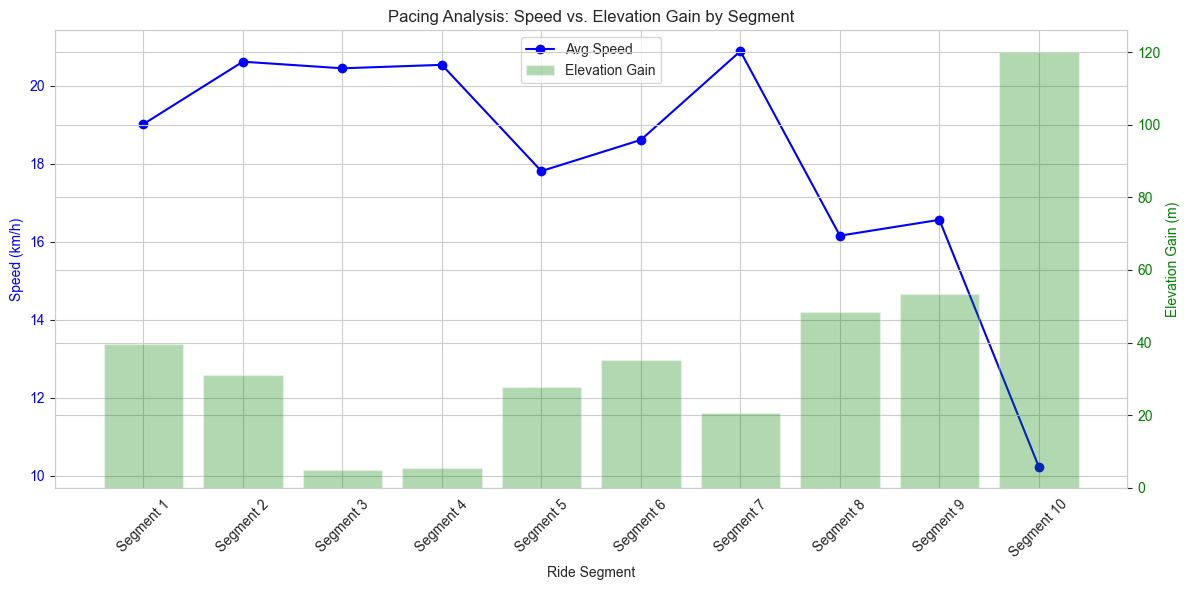

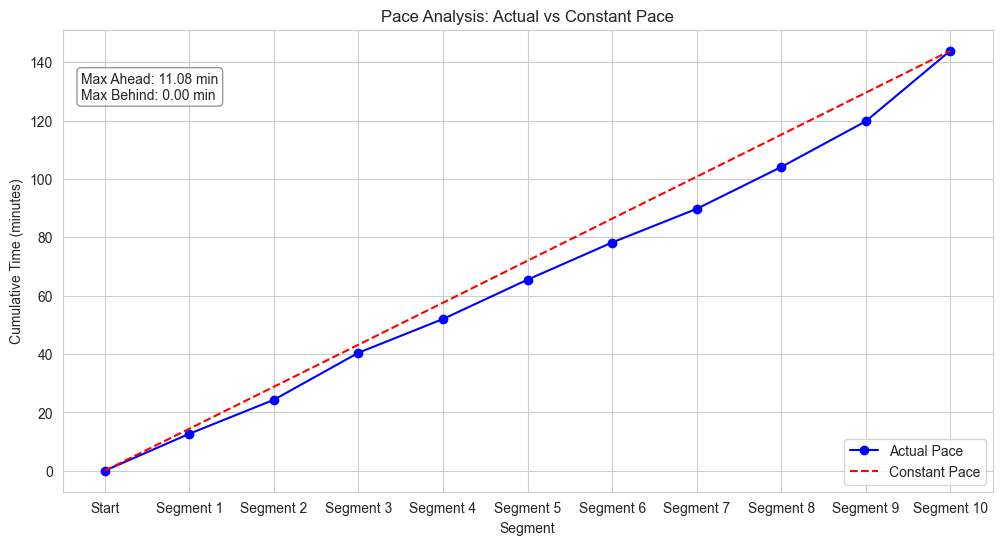

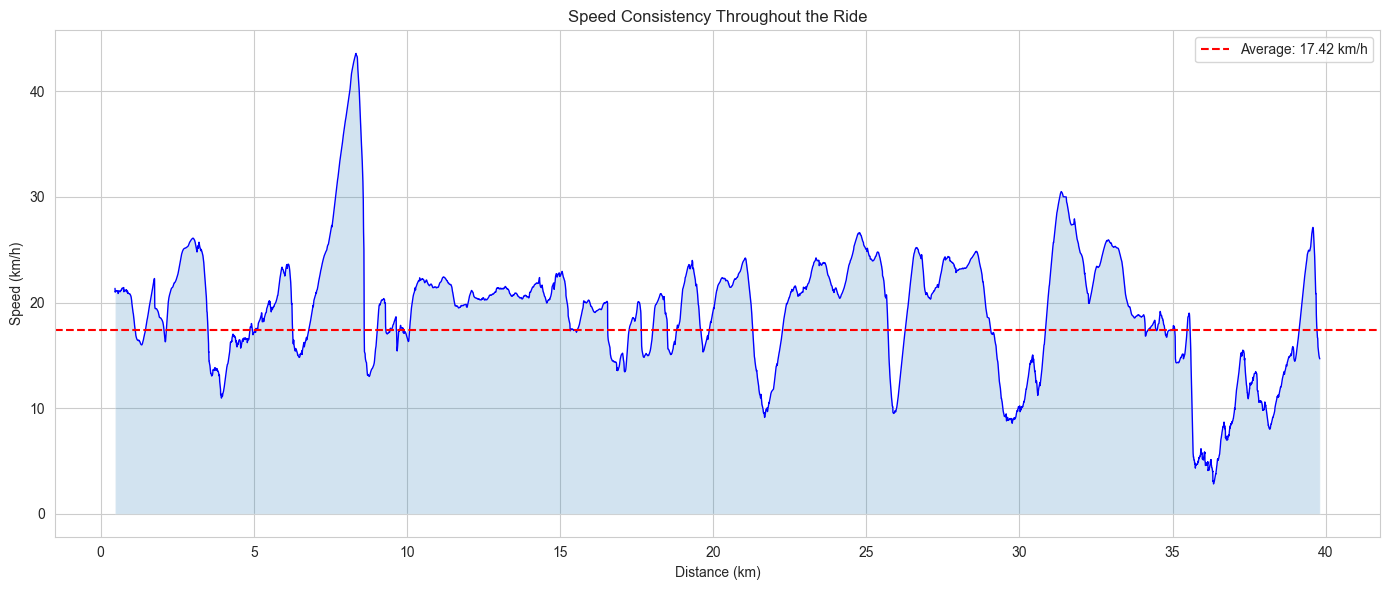

In [7]:
# Divide the ride into equal segments to analyze pacing
num_segments = 10  # Divide ride into 10 equal distance segments
segment_length = df["cumulative_distance"].iloc[-1] / num_segments

# Create bins for segmenting the ride
distance_bins = [i * segment_length for i in range(num_segments + 1)]
distance_labels = [f"Segment {i + 1}" for i in range(num_segments)]

# Assign each data point to a segment
df["distance_segment"] = pd.cut(
    df["cumulative_distance"],
    bins=distance_bins,
    labels=distance_labels,
    include_lowest=True,
)

# Calculate average speed, time, and other metrics for each segment
segment_stats = (
    df.groupby("distance_segment")
    .agg(
        {
            "speed_kmh": "mean",
            "time_diff": "sum",  # Time spent in each segment
            "elevation_diff": lambda x: x[
                x > 0
            ].sum(),  # Elevation gain in each segment
            "gradient_smooth": "mean",
        }
    )
    .reset_index()
)

# Calculate cumulative time at the end of each segment
segment_stats["cumulative_time"] = segment_stats["time_diff"].cumsum()
segment_stats["segment_distance"] = segment_length / 1000  # Convert to km
segment_stats["cumulative_distance"] = [
    (i + 1) * segment_length / 1000 for i in range(num_segments)
]

# Calculate normalized pace (speed adjusted for elevation)
segment_stats["normalized_speed"] = segment_stats["speed_kmh"] / (
    1 + segment_stats["elevation_diff"] / 100
)

print("Segment Analysis (Equal Distance Segments)")
print(
    segment_stats[
        [
            "distance_segment",
            "speed_kmh",
            "time_diff",
            "elevation_diff",
            "gradient_smooth",
            "normalized_speed",
        ]
    ]
)

# Visualize pacing strategy
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average speed for each segment
ax1.plot(
    segment_stats["distance_segment"],
    segment_stats["speed_kmh"],
    "b-o",
    label="Avg Speed",
)
ax1.set_xlabel("Ride Segment")
ax1.set_ylabel("Speed (km/h)", color="b")
ax1.tick_params(axis="y", labelcolor="b")
ax1.set_xticks(range(len(distance_labels)))
ax1.set_xticklabels(distance_labels, rotation=45)

# Create a second y-axis for elevation gain
ax2 = ax1.twinx()
ax2.bar(
    segment_stats["distance_segment"],
    segment_stats["elevation_diff"],
    alpha=0.3,
    color="g",
    label="Elevation Gain",
)
ax2.set_ylabel("Elevation Gain (m)", color="g")
ax2.tick_params(axis="y", labelcolor="g")

# Add a title
plt.title("Pacing Analysis: Speed vs. Elevation Gain by Segment")
fig.tight_layout()

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center")

plt.show()

# Create a cumulative time plot (like a virtual race against constant pace)
plt.figure(figsize=(12, 6))

# Calculate the ideal constant pace line
total_time_seconds = segment_stats["time_diff"].sum()
constant_pace_time = [
    i * total_time_seconds / num_segments for i in range(num_segments + 1)
]

# Plot actual cumulative time
actual_cumulative = np.insert(segment_stats["cumulative_time"].values, 0, 0)
plt.plot(
    np.arange(num_segments + 1), actual_cumulative / 60, "b-o", label="Actual Pace"
)

# Plot ideal constant pace
plt.plot(
    np.arange(num_segments + 1),
    np.array(constant_pace_time) / 60,
    "r--",
    label="Constant Pace",
)

# Calculate the time difference from constant pace
time_diff = actual_cumulative - constant_pace_time
max_ahead = min(time_diff) / 60 if min(time_diff) < 0 else 0
max_behind = max(time_diff) / 60 if max(time_diff) > 0 else 0

plt.xlabel("Segment")
plt.ylabel("Cumulative Time (minutes)")
plt.title("Pace Analysis: Actual vs Constant Pace")
plt.grid(True)
plt.legend()
plt.xticks(np.arange(num_segments + 1), ["Start"] + distance_labels)
plt.annotate(
    f"Max Ahead: {abs(max_ahead):.2f} min\nMax Behind: {max_behind:.2f} min",
    xy=(0.02, 0.85),
    xycoords="axes fraction",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
)
plt.show()

# Calculate and plot rolling speed to see variations and consistency
window_size = max(1, len(df) // 100)  # Adjust window size based on data points
df["rolling_speed"] = df["speed_kmh"].rolling(window=window_size).mean()

plt.figure(figsize=(14, 6))
plt.plot(df["cumulative_distance"] / 1000, df["rolling_speed"], "b-", linewidth=1)
plt.axhline(
    y=df["speed_kmh"].mean(),
    color="r",
    linestyle="--",
    label=f"Average: {df['speed_kmh'].mean():.2f} km/h",
)
plt.fill_between(df["cumulative_distance"] / 1000, df["rolling_speed"], alpha=0.2)
plt.xlabel("Distance (km)")
plt.ylabel("Speed (km/h)")
plt.title("Speed Consistency Throughout the Ride")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Effort and Terrain Analysis

Let's analyze how terrain affects performance and estimate relative effort throughout the ride.



==== Power and Effort Metrics ====
Average Power: 64 watts
Normalized Power: 97 watts
Intensity Factor (IF): 0.39
Training Stress Score (TSS): 36
Work Done: 0.2 kJ


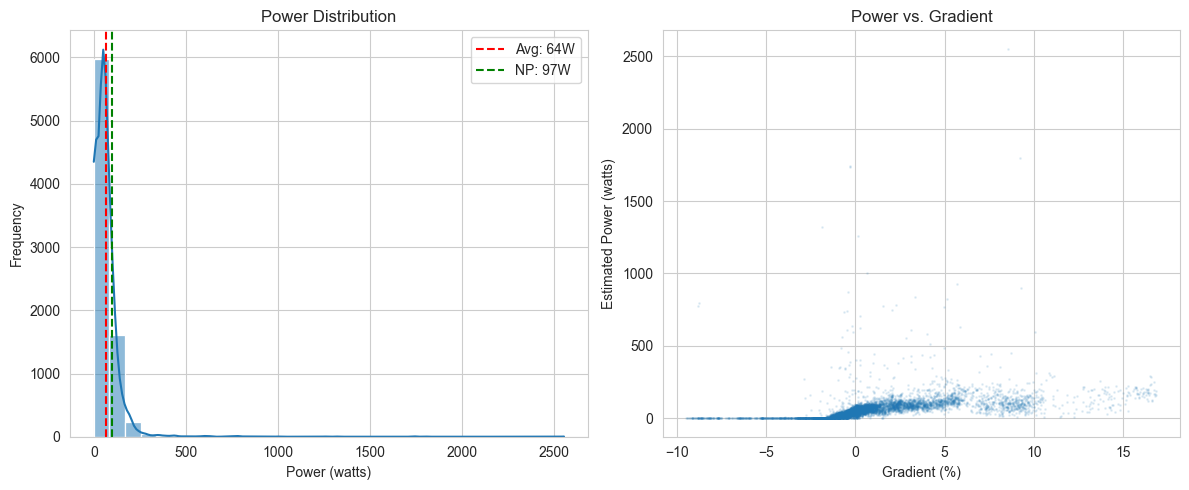

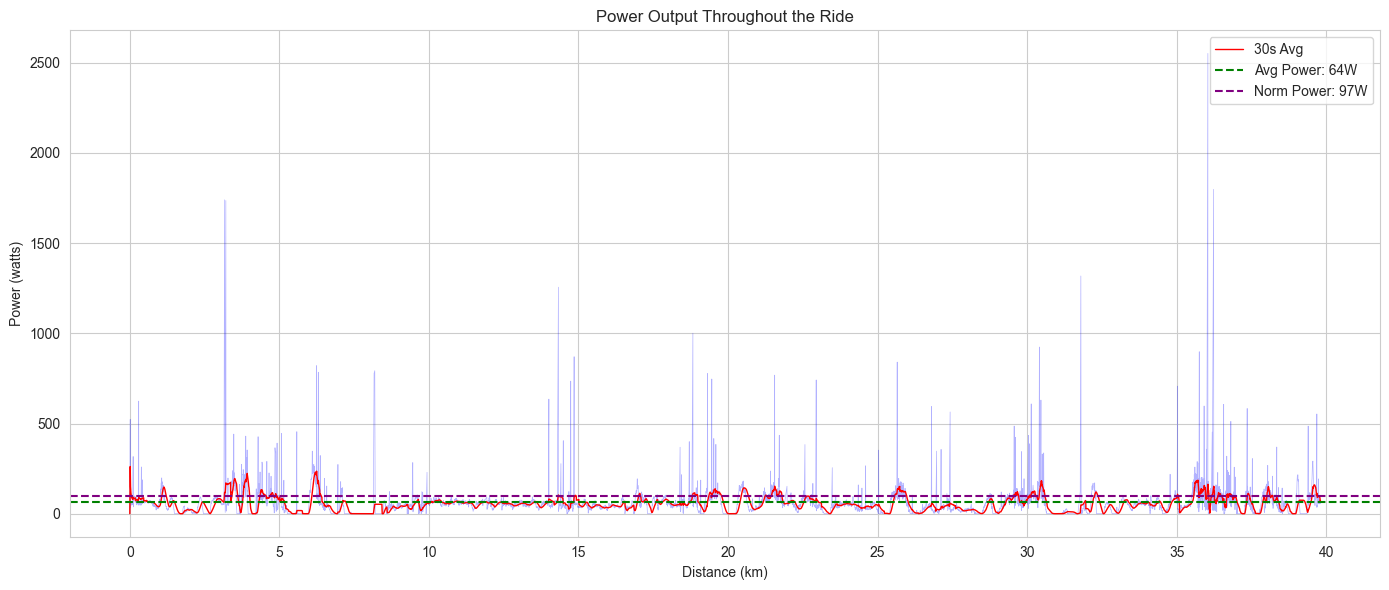


==== Energy Expenditure by Segment ====
      Segment  Energy (kJ)  Work Rate (kJ/km)  Elevation Gain (m)
0   Segment 1    62.193384          15.627490                39.7
1   Segment 2    42.752057           5.379707                31.0
2   Segment 3    35.168033           2.945481                 4.8
3   Segment 4    40.482951           2.542541                 5.5
4   Segment 5    53.371236           2.682199                27.9
5   Segment 6    55.647929           2.330398                35.3
6   Segment 7    36.570846           1.312494                20.7
7   Segment 8    55.642482           1.747536                48.4
8   Segment 9    62.407739           1.741966                53.3
9  Segment 10   105.069487           2.639478               120.0


C:\Users\milively\AppData\Local\Temp\ipykernel_32364\1430170863.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_segment")


In [8]:
# Estimate power output based on speed, gradient, and basic physics
# Note: This is a simplified model and not as accurate as actual power meter data

# Constants for power estimation
CdA = 0.3  # Aerodynamic drag coefficient * frontal area (m²)
Crr = 0.004  # Rolling resistance coefficient
rho = 1.225  # Air density (kg/m³)
gravity = 9.81  # m/s²
rider_mass = 75  # kg (assumed rider mass)
bike_mass = 8  # kg (assumed bike mass)
total_mass = rider_mass + bike_mass


# Function to estimate power based on physics model
def estimate_power(speed_mps, gradient, headwind=0):
    """
    Estimate power output in watts based on:
    - Speed in meters per second
    - Gradient as a decimal (e.g., 0.05 for 5% grade)
    - Headwind in m/s (positive for headwind, negative for tailwind)
    """
    # Convert gradient to radians
    theta = np.arctan(gradient / 100)

    # Calculate gravitational force component
    gravity_force = total_mass * gravity * np.sin(theta)

    # Calculate rolling resistance
    rolling_resistance = total_mass * gravity * np.cos(theta) * Crr

    # Calculate air resistance (with headwind adjustment)
    air_resistance = 0.5 * rho * CdA * (speed_mps + headwind) ** 2

    # Total resistive force
    total_force = gravity_force + rolling_resistance + air_resistance

    # Power = Force * Velocity
    power = total_force * speed_mps

    return max(0, power)  # Power can't be negative


# Apply the power estimation to our dataframe
df["power_estimate"] = df.apply(
    lambda row: estimate_power(
        row["speed_mps"],
        row["gradient_smooth"] if not pd.isna(row["gradient_smooth"]) else 0,
    ),
    axis=1,
)

# Calculate rolling averages for power
df["power_30s"] = df["power_estimate"].rolling(window=30, min_periods=1).mean()

# Calculate normalized power (a simplified version)
# First, raise the 30s power to the 4th power
df["power_30s_4th"] = df["power_30s"] ** 4

# Take the average of the 4th power values
avg_power_4th = df["power_30s_4th"].mean()

# Take the 4th root of the average to get normalized power
normalized_power = avg_power_4th ** (1 / 4)

# Calculate average power
average_power = df["power_estimate"].mean()

# Calculate Intensity Factor (IF) and Training Stress Score (TSS)
# Assuming a functional threshold power (FTP) of 250 watts (adjust as needed)
FTP = 250  # Functional Threshold Power in watts
intensity_factor = normalized_power / FTP
ride_duration_hours = (df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds() / 3600
training_stress = 100 * (normalized_power / FTP) ** 2 * ride_duration_hours

# Print power metrics
print("\n==== Power and Effort Metrics ====")
print(f"Average Power: {average_power:.0f} watts")
print(f"Normalized Power: {normalized_power:.0f} watts")
print(f"Intensity Factor (IF): {intensity_factor:.2f}")
print(f"Training Stress Score (TSS): {training_stress:.0f}")
print(f"Work Done: {average_power * ride_duration_hours / 1000:.1f} kJ")

# Visualize power distribution
plt.figure(figsize=(12, 5))

# Power histogram
plt.subplot(1, 2, 1)
sns.histplot(df["power_estimate"].dropna(), bins=30, kde=True)
plt.axvline(
    x=average_power, color="r", linestyle="--", label=f"Avg: {average_power:.0f}W"
)
plt.axvline(
    x=normalized_power, color="g", linestyle="--", label=f"NP: {normalized_power:.0f}W"
)
plt.xlabel("Power (watts)")
plt.ylabel("Frequency")
plt.title("Power Distribution")
plt.legend()
plt.grid(True)

# Power vs. gradient scatterplot
plt.subplot(1, 2, 2)
plt.scatter(df["gradient_smooth"], df["power_estimate"], alpha=0.1, s=1)
plt.xlabel("Gradient (%)")
plt.ylabel("Estimated Power (watts)")
plt.title("Power vs. Gradient")
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize power over the course of the ride
plt.figure(figsize=(14, 6))
plt.plot(
    df["cumulative_distance"] / 1000,
    df["power_estimate"],
    "b-",
    alpha=0.3,
    linewidth=0.5,
)
plt.plot(
    df["cumulative_distance"] / 1000,
    df["power_30s"],
    "r-",
    linewidth=1,
    label="30s Avg",
)
plt.axhline(
    y=average_power, color="g", linestyle="--", label=f"Avg Power: {average_power:.0f}W"
)
plt.axhline(
    y=normalized_power,
    color="purple",
    linestyle="--",
    label=f"Norm Power: {normalized_power:.0f}W",
)
plt.xlabel("Distance (km)")
plt.ylabel("Power (watts)")
plt.title("Power Output Throughout the Ride")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and display work done (energy expended) by segment
energy_by_segment = (
    df.groupby("distance_segment")
    .agg(
        {
            "power_estimate": lambda x: (x.mean() * len(x) * df["time_diff"].mean())
            / 1000,  # kJ
            "cumulative_distance": lambda x: x.max() / 1000,  # km
            "elevation_diff": lambda x: x[x > 0].sum(),  # m
        }
    )
    .reset_index()
)

energy_by_segment.columns = [
    "Segment",
    "Energy (kJ)",
    "Distance (km)",
    "Elevation Gain (m)",
]
energy_by_segment["Work Rate (kJ/km)"] = (
    energy_by_segment["Energy (kJ)"] / energy_by_segment["Distance (km)"]
)
energy_by_segment["Elevation Energy Ratio"] = (
    energy_by_segment["Energy (kJ)"] / energy_by_segment["Elevation Gain (m)"]
)

print("\n==== Energy Expenditure by Segment ====")
print(
    energy_by_segment[
        ["Segment", "Energy (kJ)", "Work Rate (kJ/km)", "Elevation Gain (m)"]
    ]
)

## Weather Impact Analysis

Weather can significantly impact cycling performance. Let's check if we can extract timestamp information from the GPX file and use that to estimate weather conditions during the ride.


Ride started at: 2024-12-01 18:05:07+00:00
Ride ended at: 2024-12-01 20:29:04+00:00
Time of day: 18:05 - 20:29
Date: 2024-12-01
Day of week: Sunday


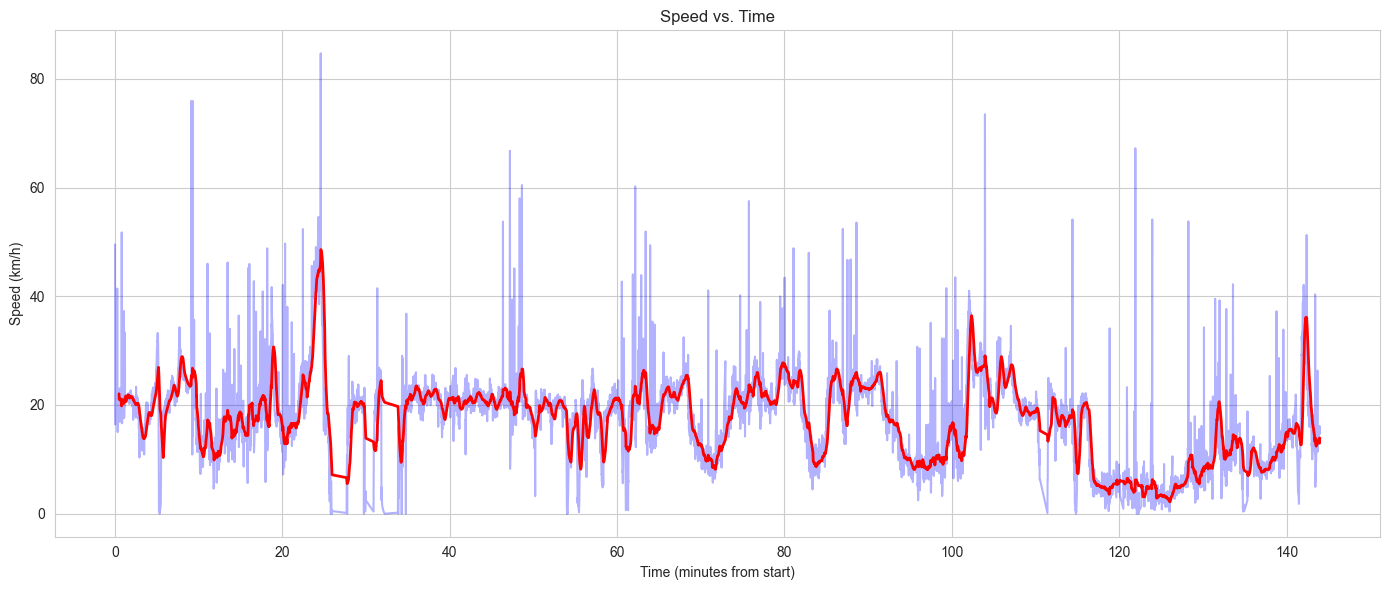


==== Speed Analysis by Direction ====
  direction       mean       std  count
6        SW  21.383937  6.777103    628
3        NW  20.950086  6.621628    901
7         W  19.254853  6.691804    992
1         N  18.460449  8.169986   1117
4         S  17.086486  7.386423   1057
5        SE  16.228137  7.967617   1662
0         E  14.298561  7.161169    875
2        NE  12.156922  9.228975    685


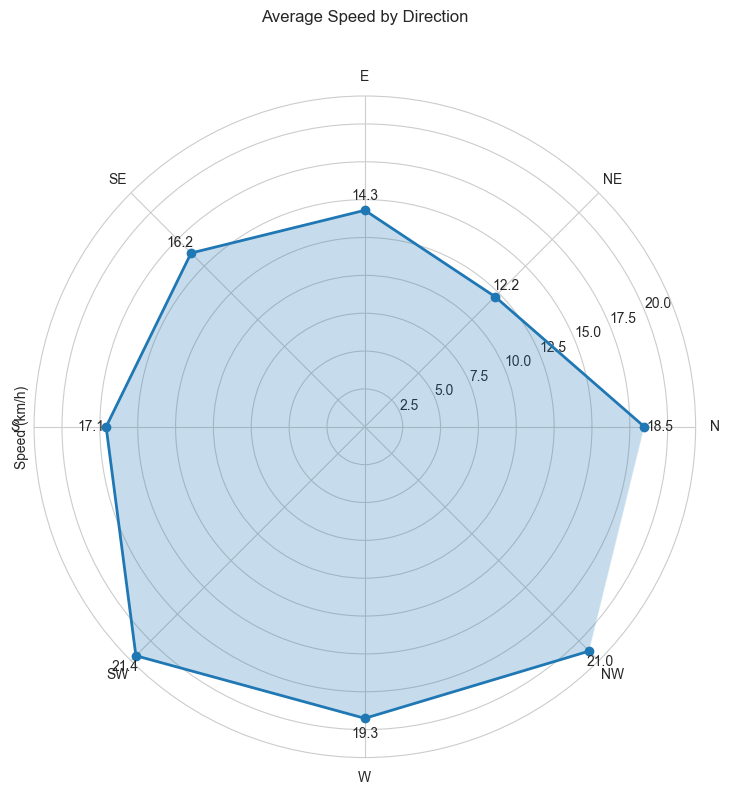


==== Wind Effect Estimate ====
North-South speed difference: 1.37 km/h
East-West speed difference: 4.96 km/h
Northeast-Southwest speed difference: 9.23 km/h
Northwest-Southeast speed difference: 4.72 km/h

Possible wind detected: Max speed difference between opposing directions is 9.23 km/h
Likely wind from the East


In [10]:
# Extract time information from the GPX data
start_time = df["time"].min()
end_time = df["time"].max()

print(f"Ride started at: {start_time}")
print(f"Ride ended at: {end_time}")
print(f"Time of day: {start_time.strftime('%H:%M')} - {end_time.strftime('%H:%M')}")
print(f"Date: {start_time.strftime('%Y-%m-%d')}")
print(f"Day of week: {start_time.strftime('%A')}")

# Create a time-based analysis
df["minutes_from_start"] = (df["time"] - start_time).dt.total_seconds() / 60
df["hour_of_day"] = df["time"].dt.hour + df["time"].dt.minute / 60

# Time-based speed analysis
plt.figure(figsize=(14, 6))
plt.plot(df["minutes_from_start"], df["speed_kmh"], "b-", alpha=0.3)
plt.plot(
    df["minutes_from_start"],
    df["speed_kmh"].rolling(window=30).mean(),
    "r-",
    linewidth=2,
)
plt.xlabel("Time (minutes from start)")
plt.ylabel("Speed (km/h)")
plt.title("Speed vs. Time")
plt.grid(True)
plt.tight_layout()
plt.show()


# Check for evidence of wind effects
# We'll look for patterns in speed variations based on direction
# First, calculate the bearing/direction of travel for each point
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the compass bearing between two points.
    Formula from: https://www.movable-type.co.uk/scripts/latlong.html
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dL = lon2 - lon1

    x = np.cos(lat2) * np.sin(dL)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dL)

    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing


# Calculate direction of travel
df["bearing"] = df.apply(
    lambda row: calculate_bearing(
        row["prev_lat"], row["prev_lon"], row["latitude"], row["longitude"]
    )
    if not pd.isna(row["prev_lat"])
    else np.nan,
    axis=1,
)


# Convert bearing to cardinal direction
def bearing_to_cardinal(bearing):
    """Convert bearing in degrees to cardinal direction"""
    directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW", "N"]
    return directions[int((bearing + 22.5) % 360) // 45]


df["direction"] = df["bearing"].apply(
    lambda x: bearing_to_cardinal(x) if not pd.isna(x) else np.nan
)

# Analyze speed by direction - this can help identify if there was a headwind/tailwind
direction_speed = (
    df.groupby("direction")["speed_kmh"].agg(["mean", "std", "count"]).reset_index()
)
direction_speed = direction_speed[
    direction_speed["count"] > 100
]  # Only include directions with enough data points
direction_speed.sort_values("mean", ascending=False, inplace=True)

print("\n==== Speed Analysis by Direction ====")
print(direction_speed)

# Plot speed by direction as a radar chart
if len(direction_speed) > 0:
    plt.figure(figsize=(10, 8))

    # Define the cardinal directions in order
    cardinals = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]

    # Create a dictionary mapping direction to mean speed
    speed_by_dir = dict(zip(direction_speed["direction"], direction_speed["mean"]))

    # Get speeds for all cardinal directions, with 0 for missing directions
    speeds = [speed_by_dir.get(direction, 0) for direction in cardinals]

    # Set up radar chart - make sure arrays have the same length
    angles = np.linspace(0, 2 * np.pi, len(cardinals), endpoint=False).tolist()

    # Plot without closing the loop
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, speeds, "o-", linewidth=2)
    ax.fill(angles, speeds, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles), cardinals)
    ax.set_ylabel("Speed (km/h)")
    ax.set_title("Average Speed by Direction", y=1.1)

    # Add labels
    for angle, radius in zip(angles, speeds):
        plt.text(
            angle, radius + 1, f"{radius:.1f}", ha="center", va="center", fontsize=10
        )

    plt.tight_layout()
    plt.show()

    # Calculate wind effect estimate
    # If there's a significant difference between opposing directions, it could indicate wind
    print("\n==== Wind Effect Estimate ====")
    if all(d in speed_by_dir for d in ["N", "S"]):
        ns_diff = abs(speed_by_dir["N"] - speed_by_dir["S"])
        print(f"North-South speed difference: {ns_diff:.2f} km/h")

    if all(d in speed_by_dir for d in ["E", "W"]):
        ew_diff = abs(speed_by_dir["E"] - speed_by_dir["W"])
        print(f"East-West speed difference: {ew_diff:.2f} km/h")

    if all(d in speed_by_dir for d in ["NE", "SW"]):
        nesw_diff = abs(speed_by_dir["NE"] - speed_by_dir["SW"])
        print(f"Northeast-Southwest speed difference: {nesw_diff:.2f} km/h")

    if all(d in speed_by_dir for d in ["NW", "SE"]):
        nwse_diff = abs(speed_by_dir["NW"] - speed_by_dir["SE"])
        print(f"Northwest-Southeast speed difference: {nwse_diff:.2f} km/h")

    # Check if there could be wind effects
    threshold = 3.0  # km/h difference threshold
    diffs = []

    if all(d in speed_by_dir for d in ["N", "S"]):
        diffs.append(abs(speed_by_dir["N"] - speed_by_dir["S"]))
    if all(d in speed_by_dir for d in ["E", "W"]):
        diffs.append(abs(speed_by_dir["E"] - speed_by_dir["W"]))
    if all(d in speed_by_dir for d in ["NE", "SW"]):
        diffs.append(abs(speed_by_dir["NE"] - speed_by_dir["SW"]))
    if all(d in speed_by_dir for d in ["NW", "SE"]):
        diffs.append(abs(speed_by_dir["NW"] - speed_by_dir["SE"]))

    if diffs and max(diffs) > threshold:
        print(
            f"\nPossible wind detected: Max speed difference between opposing directions is {max(diffs):.2f} km/h"
        )
        # Try to determine wind direction
        if (
            all(d in speed_by_dir for d in ["N", "S"])
            and abs(speed_by_dir["N"] - speed_by_dir["S"]) > threshold
        ):
            wind_dir = "South" if speed_by_dir["N"] > speed_by_dir["S"] else "North"
            print(f"Likely wind from the {wind_dir}")
        elif (
            all(d in speed_by_dir for d in ["E", "W"])
            and abs(speed_by_dir["E"] - speed_by_dir["W"]) > threshold
        ):
            wind_dir = "West" if speed_by_dir["E"] > speed_by_dir["W"] else "East"
            print(f"Likely wind from the {wind_dir}")
    else:
        print(
            "\nNo significant wind effects detected based on directional speed differences."
        )

## Performance on Different Terrain Types

Let's analyze how performance changes on different terrain types: climbs, flats, and descents.


==== Performance by Terrain Type ====
Terrain    Distance   % Total    Avg Speed  Avg Power 
------------------------------------------------------------
flat          28.91 km     72.6%     19.3 km/h     49.4 W
climb          5.85 km     14.7%      9.6 km/h    118.8 W
descent        5.04 km     12.7%     26.5 km/h      3.5 W

==== Detailed Performance by Climb Category ====
Category        Distance   % Total    Avg Speed  Avg Power  Avg Gradient
----------------------------------------------------------------------
steep climb         2.84 km      7.1%      7.7 km/h    131.2 W      7.6%
easy climb          3.01 km      7.6%     12.3 km/h    101.4 W      2.9%
not a climb        28.91 km     72.6%     19.3 km/h     49.4 W     -0.1%
easy descent        2.54 km      6.4%     23.5 km/h      2.0 W     -2.7%
steep descent       2.50 km      6.3%     30.3 km/h      5.3 W     -6.4%


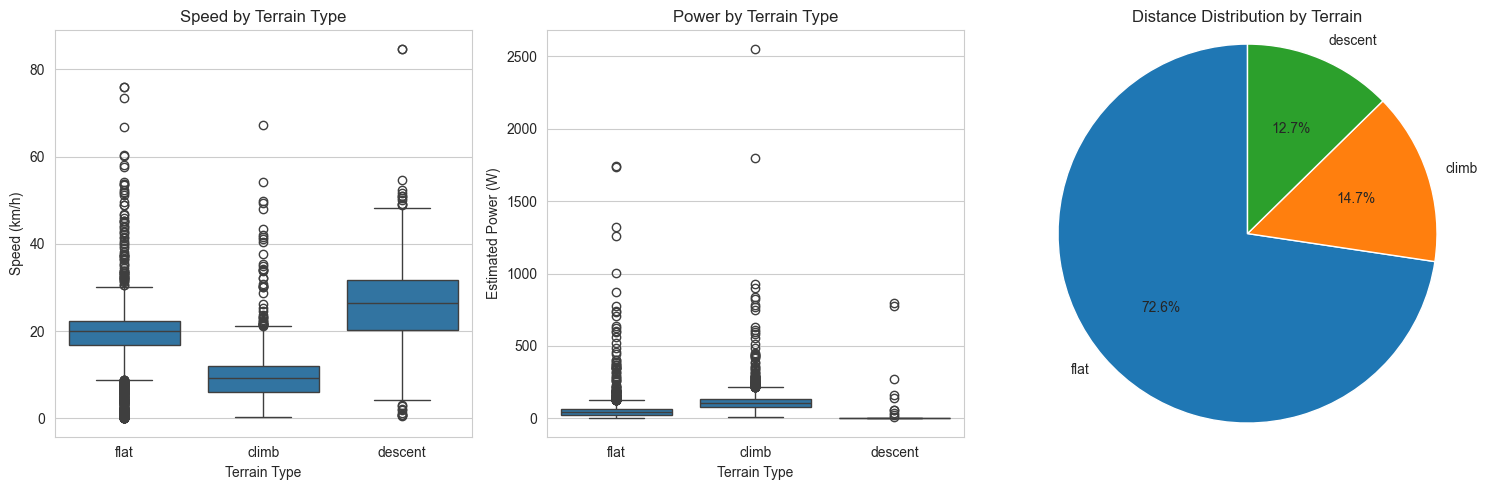

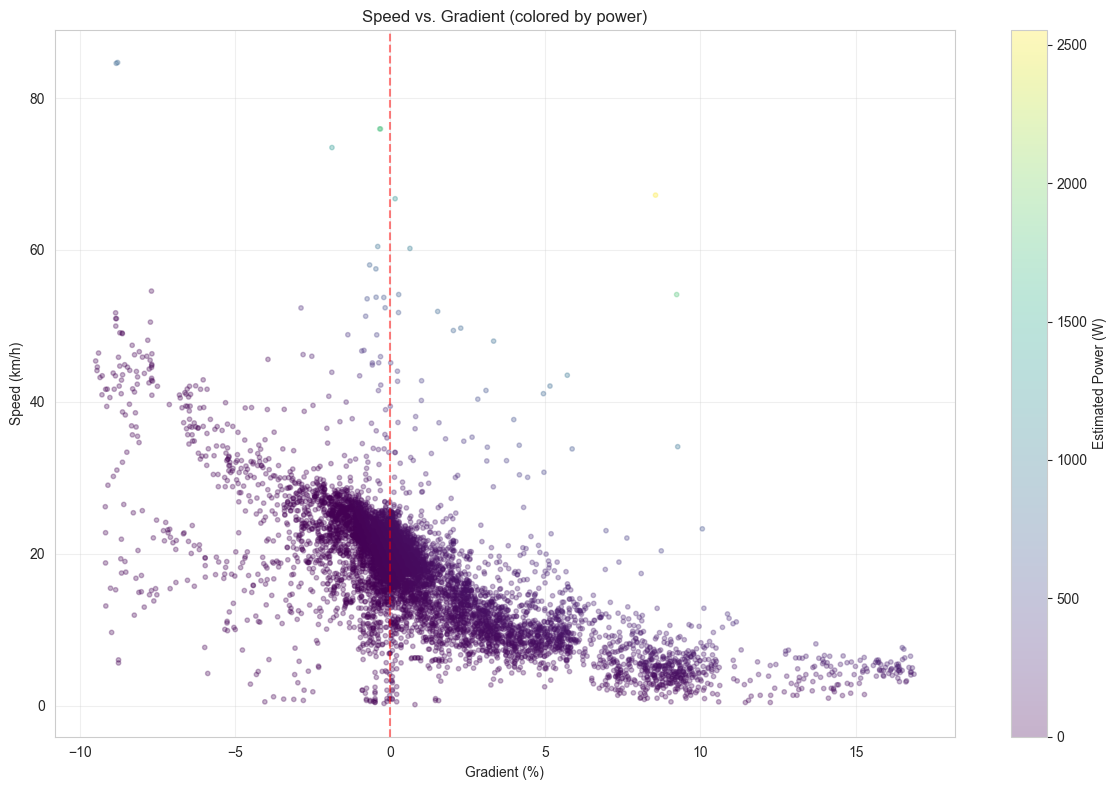

KeyError: 'terrain'

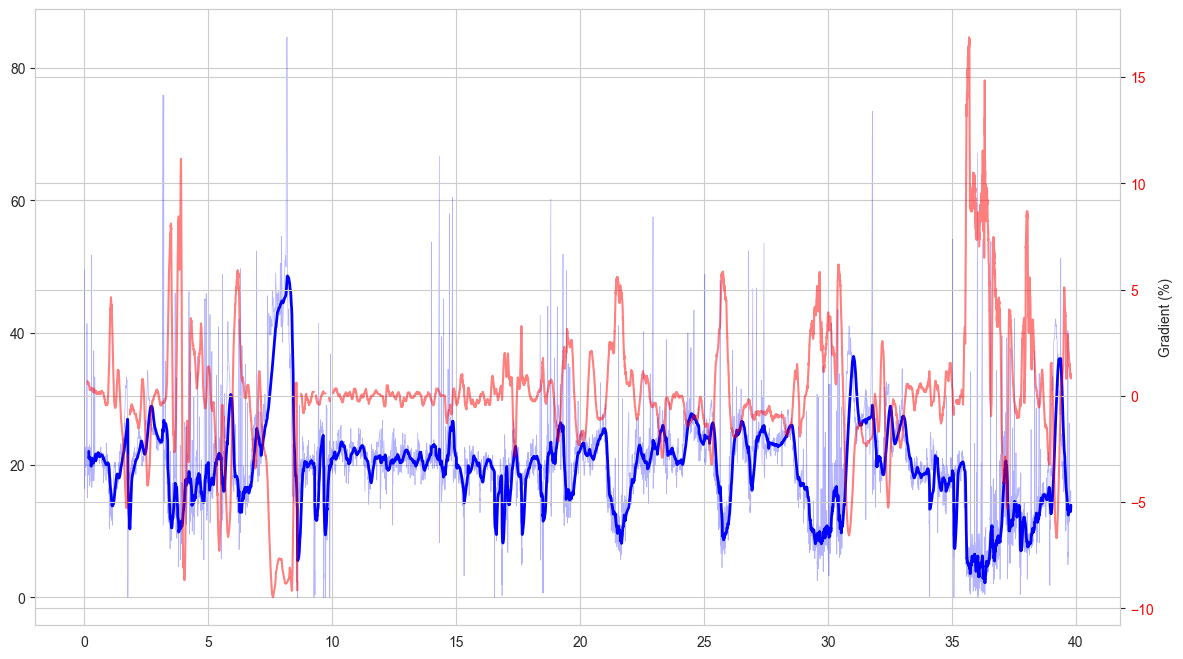

In [ ]:
# Categorize terrain types based on gradient
# Define gradient thresholds for terrain types
flat_threshold = 2.0  # %
climb_threshold = 4.0  # %

# Classify each point based on gradient
df["terrain"] = "flat"
df.loc[df["gradient_smooth"] > flat_threshold, "terrain"] = "climb"
df.loc[df["gradient_smooth"] < -flat_threshold, "terrain"] = "descent"

# Add more detail - categorize climbs by steepness
df["climb_category"] = "not a climb"
df.loc[
    (df["gradient_smooth"] > flat_threshold)
    & (df["gradient_smooth"] <= climb_threshold),
    "climb_category",
] = "easy climb"
df.loc[df["gradient_smooth"] > climb_threshold, "climb_category"] = "steep climb"
df.loc[
    (df["gradient_smooth"] < -flat_threshold)
    & (df["gradient_smooth"] >= -climb_threshold),
    "climb_category",
] = "easy descent"
df.loc[df["gradient_smooth"] < -climb_threshold, "climb_category"] = "steep descent"

# Calculate statistics by terrain type
terrain_stats = (
    df.groupby("terrain")
    .agg(
        {
            "speed_kmh": ["mean", "max", "min", "std"],
            "power_estimate": ["mean", "max", "min"],
            "distance": "sum",
            "time_diff": "sum",
            "gradient_smooth": ["mean", "min", "max"],
        }
    )
    .reset_index()
)

# Format the multi-level columns for easier reading
terrain_stats.columns = [
    f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in terrain_stats.columns
]

# Calculate percentage of total distance
total_distance = terrain_stats["distance_sum"].sum()
terrain_stats["percent_distance"] = (
    terrain_stats["distance_sum"] / total_distance
) * 100

# Sort by percentage of distance
terrain_stats = terrain_stats.sort_values("percent_distance", ascending=False)

# Print terrain statistics
print("==== Performance by Terrain Type ====")
print(
    f"{'Terrain':<10} {'Distance':<10} {'% Total':<10} {'Avg Speed':<10} {'Avg Power':<10}"
)
print("-" * 60)

for _, row in terrain_stats.iterrows():
    terrain = row["terrain"]
    distance_km = row["distance_sum"] / 1000
    percent = row["percent_distance"]
    avg_speed = row["speed_kmh_mean"]
    avg_power = row["power_estimate_mean"]

    print(
        f"{terrain:<10} {distance_km:8.2f} km {percent:8.1f}% {avg_speed:8.1f} km/h {avg_power:8.1f} W"
    )

# Now do the same for more detailed climb categories
detailed_stats = (
    df.groupby("climb_category")
    .agg(
        {
            "speed_kmh": ["mean", "max", "min"],
            "power_estimate": ["mean", "max"],
            "distance": "sum",
            "time_diff": "sum",
            "gradient_smooth": ["mean", "min", "max"],
        }
    )
    .reset_index()
)

# Format the multi-level columns
detailed_stats.columns = [
    f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in detailed_stats.columns
]

# Calculate percentage of total distance
detailed_stats["percent_distance"] = (
    detailed_stats["distance_sum"] / total_distance
) * 100

# Sort by average gradient
detailed_stats = detailed_stats.sort_values("gradient_smooth_mean", ascending=False)

print("\n==== Detailed Performance by Climb Category ====")
print(
    f"{'Category':<15} {'Distance':<10} {'% Total':<10} {'Avg Speed':<10} {'Avg Power':<10} {'Avg Gradient':<12}"
)
print("-" * 70)

for _, row in detailed_stats.iterrows():
    category = row["climb_category"]
    distance_km = row["distance_sum"] / 1000
    percent = row["percent_distance"]
    avg_speed = row["speed_kmh_mean"]
    avg_power = row["power_estimate_mean"]
    avg_gradient = row["gradient_smooth_mean"]

    print(
        f"{category:<15} {distance_km:8.2f} km {percent:8.1f}% {avg_speed:8.1f} km/h {avg_power:8.1f} W {avg_gradient:8.1f}%"
    )

# Create visualizations of performance by terrain type
plt.figure(figsize=(15, 5))

# Plot 1: Speed by terrain type
plt.subplot(1, 3, 1)
sns.boxplot(x="terrain", y="speed_kmh", data=df)
plt.xlabel("Terrain Type")
plt.ylabel("Speed (km/h)")
plt.title("Speed by Terrain Type")

# Plot 2: Power by terrain type
plt.subplot(1, 3, 2)
sns.boxplot(x="terrain", y="power_estimate", data=df)
plt.xlabel("Terrain Type")
plt.ylabel("Estimated Power (W)")
plt.title("Power by Terrain Type")

# Plot 3: Pie chart of distance by terrain
plt.subplot(1, 3, 3)
plt.pie(
    terrain_stats["percent_distance"],
    labels=terrain_stats["terrain"],
    autopct="%1.1f%%",
    startangle=90,
)
plt.axis("equal")
plt.title("Distance Distribution by Terrain")

plt.tight_layout()
plt.show()

# Scatter plot of speed vs. gradient, colored by power
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df["gradient_smooth"],
    df["speed_kmh"],
    c=df["power_estimate"],
    cmap="viridis",
    alpha=0.3,
    s=10,
)
plt.colorbar(scatter, label="Estimated Power (W)")
plt.xlabel("Gradient (%)")
plt.ylabel("Speed (km/h)")
plt.title("Speed vs. Gradient (colored by power)")
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color="r", linestyle="--", alpha=0.5)  # Mark flat terrain
plt.tight_layout()
plt.show()

# Visualize speed profile through different terrain sections
plt.figure(figsize=(14, 8))

# Create sequential colormap for terrain
terrain_colors = {"flat": "gray", "climb": "red", "descent": "green"}
terrain_scatter = []

# Plot speed over distance
plt.plot(
    df["cumulative_distance"] / 1000, df["speed_kmh"], "b-", alpha=0.3, linewidth=0.5
)
plt.plot(
    df["cumulative_distance"] / 1000,
    df["speed_kmh"].rolling(window=30).mean(),
    "b-",
    linewidth=2,
    label="Speed (30s avg)",
)

# Add gradient on secondary axis
ax2 = plt.twinx()
ax2.plot(
    df["cumulative_distance"] / 1000,
    df["gradient_smooth"],
    "r-",
    alpha=0.5,
    label="Gradient",
)
ax2.set_ylabel("Gradient (%)")
ax2.tick_params(axis="y", labelcolor="r")

# Add terrain-type background
terrain_changes = df["terrain"].ne(df["terrain"].shift()).cumsum()
terrain_sections = df.groupby(terrain_changes).agg(
    {"terrain": "first", "cumulative_distance": ["min", "max"]}
)

# Format column names
terrain_sections.columns = [
    f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in terrain_sections.columns
]

for _, section in terrain_sections.iterrows():
    start = section["cumulative_distance_min"] / 1000
    end = section["cumulative_distance_max"] / 1000
    terrain = section["terrain"]

    # Shade the background based on terrain
    plt.axvspan(start, end, alpha=0.2, color=terrain_colors.get(terrain, "gray"))

plt.xlabel("Distance (km)")
plt.ylabel("Speed (km/h)")
plt.title("Speed and Gradient Profile with Terrain Highlighting")
plt.grid(True)

# Create a combined legend
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Add custom patches for terrain types
patches = [
    plt.Rectangle((0, 0), 1, 1, alpha=0.2, color=terrain_colors[t])
    for t in terrain_colors
]
patch_labels = list(terrain_colors.keys())

plt.legend(
    lines1 + lines2 + patches,
    labels1 + labels2 + patch_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
)

plt.tight_layout()
plt.show()